In [1]:
# Import necessary libraries
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [2]:
# Define function to parse logs
def parse_logs(log_file):
    
    # Initialize variables
    data = []
    current_round = None
    current_network = None
    global_top1 = None
    global_top5 = None
    last_global_top1 = None
    last_global_top5 = None

    with open(log_file, 'r') as file:
        for line in file:
            round_match = re.search(r"in comm round:(\d+)", line)
            network_match = re.search(r"Training network (\d+)", line)
            epoch_match = re.search(r"Epoch: (\d+) Loss: (-?\d+\.\d+)", line)
            global_top1_match = re.search(r"Global Model Test accuracy Top1: (\d+\.\d+)", line)
            global_top5_match = re.search(r"Global Model Test accuracy Top5: (\d+\.\d+)", line)

            if round_match:
                current_round = int(round_match.group(1))
            elif network_match:
                current_network = int(network_match.group(1))
            elif epoch_match:
                epoch = int(epoch_match.group(1))
                loss = float(epoch_match.group(2))
                #data.append([current_round, current_network, epoch, loss, None, None])
                data.append([current_round, current_network, epoch, loss, last_global_top1, last_global_top5])
            elif global_top1_match:
                #global_top1 = float(global_top1_match.group(1))
                last_global_top1 = float(global_top1_match.group(1))
            elif global_top5_match:
                #global_top5 = float(global_top5_match.group(1))
                last_global_top5 = float(global_top5_match.group(1))
                #for row in data:
                #    row[4] = global_top1
                #    row[5] = global_top5
            
            df = pd.DataFrame(data, columns=['comm_round', 'net', 'epch', 'loss', 'g_acc@1', 'g_acc@5'])

    return df


In [3]:
# Function to extract metadata from log filename
def extract_metadata(filename):
    match = re.match(
        r"(?P<dataset>[^-]+)-(?P<portion>[^-]+)-(?P<method>[^-]+)-(?P<batch_size>[^-]+)-(?P<n_parties>[^-]+)-(?P<temperature>[^-]+)-(?P<tt>[^-]+)-(?P<ts>[^-]+)-(?P<epochs>[^_]+)_log-(?P<timestamp>\d{4}-\d{2}-\d{2}-\d{2}\d{2}-\d{2})",
        filename
    )
    if match:
        return match.groupdict()
    return {}


In [4]:
# Load data from all log files in the logs folder
log_folder = "./logs"
log_files = [os.path.join(log_folder, f) for f in os.listdir(log_folder) if f.endswith(".log")]

# Process and combine data from all log files
dataframes = {}
for log_file in log_files:
  filename = os.path.basename(log_file)
  metadata = extract_metadata(filename)
  df = parse_logs(log_file)
  for key, value in metadata.items():
    df[key] = value
  dataframes[filename] = df
  

In [5]:
combined_df = pd.concat(dataframes.values(), ignore_index=True)

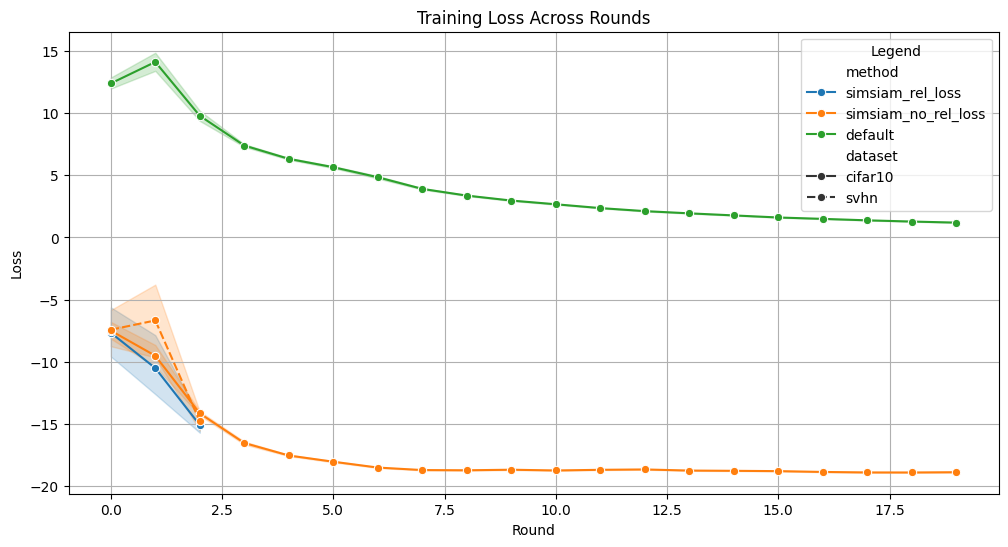

In [6]:
# Plot Losses with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_df, 
    x="comm_round", 
    y="loss", 
    hue="method",
    style="dataset",
    marker="o"
)
plt.title("Training Loss Across Rounds")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend(title="Legend")
plt.grid()
plt.show()

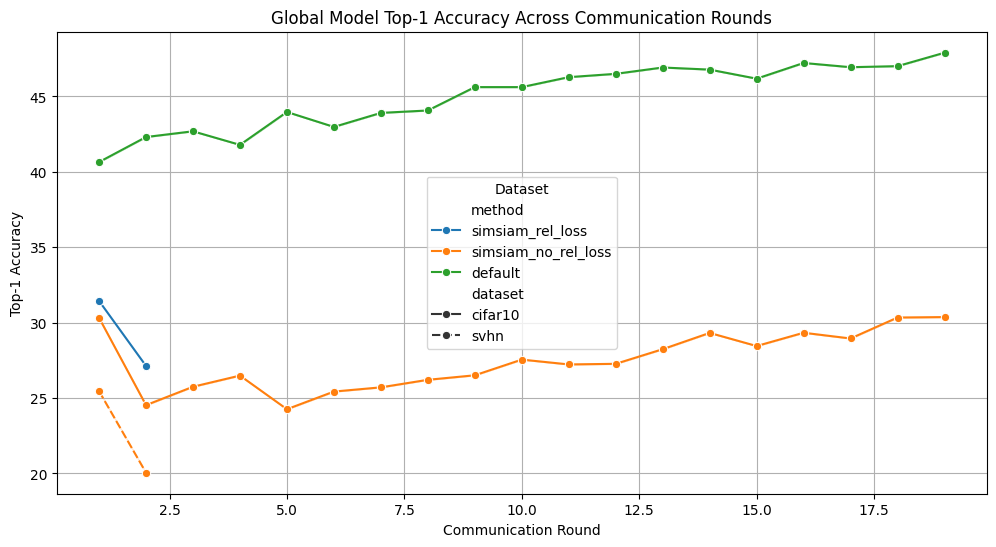

In [7]:
# Plot Global Accuracy Top1 with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_df,
    x="comm_round",
    y="g_acc@1",
    hue="method",
    style="dataset",
    marker="o"
)
plt.title("Global Model Top-1 Accuracy Across Communication Rounds")
plt.xlabel("Communication Round")
plt.ylabel("Top-1 Accuracy")
plt.legend(title="Dataset")
plt.grid()
plt.show()

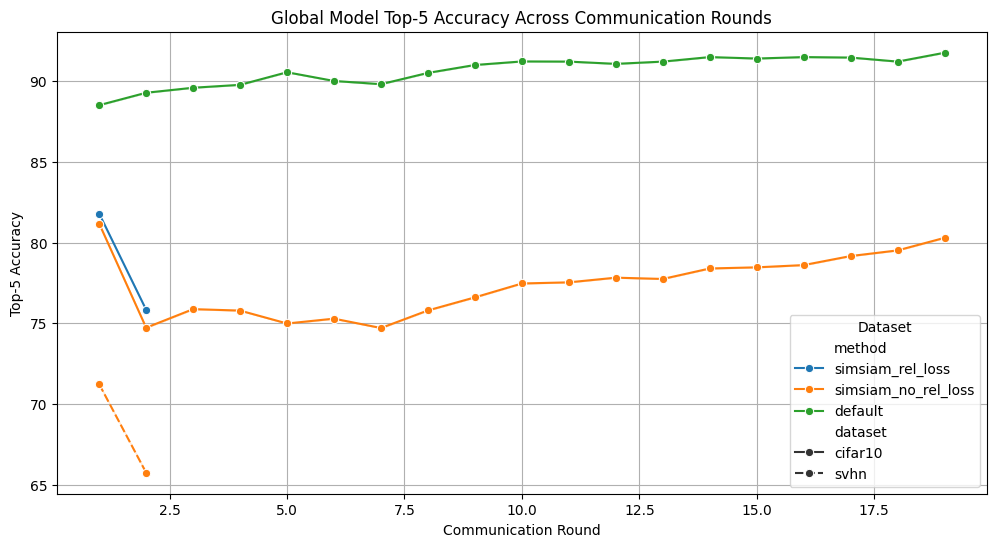

In [8]:
# Plot Global Accuracy Top5 with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_df,
    x="comm_round",
    y="g_acc@5",
    hue="method",
    style="dataset",
    marker="o"
)
plt.title("Global Model Top-5 Accuracy Across Communication Rounds")
plt.xlabel("Communication Round")
plt.ylabel("Top-5 Accuracy")
plt.legend(title="Dataset")
plt.grid()
plt.show()